In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation, rc

from lectures_helpers import animate_poly_minimization, animate_poly_minimization_with_slope

%matplotlib inline

## О машинном обучении (в терминах и абстракциях)

### Что мы хотим?

**На вход**: имеющиеся данные о объекте (*объект* - это вообще что либо с чем мы работаем: картинки, люди, события, и т.д.)  
**На выход**: какая-то неочевидная из данных информация об этом объекте

#### Примеры:  
**На вход**: пиксели изображения  
**На выход**: изображен котик или собачка (для компьютера это совсем неочевидное свойство изображения)

**На вход**: вес, рост, возраст, температура, анализ крови  
**На выход**: наличие гриппа у человека

**На вход**: цены на нефть за полследний год  
**На выход**: цена на нефть завтра

<img src="pics/ML_forward.png">

### Типы задач

Задачки можно поделить используя две разных классификации.

1) По наличию данных:
* Если у нас есть данные для обучения, которые содержат правильные предсказания. Напрмер, у нас есть картинки где известно где котики а где собачки. Такие задачки называются **обучение с учителем** или **supervised learning**
* Если у нас есть только сырые данные без примеров правильных предсказаний. Такие задачки называются **обучение без учителя** или **unsupervised learning**

2) По типу предсказаний:
* Если предсказания это какие то категории: котик/собачка, болен/не болен, красный/синий/зеленый и т.д., то такая задачка называется **классификацией**. То есть отнесение объектов к разным **классам**. Если варианта всего два (котик/собачка) то это **бинарная классификация**.
* Если предсказания это какие то численные величины: цены на нефть, температура воздуха, то такая задачка называется **регрессией**.

**Далее мы будем говорить только о задачках *обучения с учителем*.**

### Об алгоритмах и параметрах

Алгоритмы машинного обучения имеют два типа параметров: **настраиваемые** (learnable) и **гиперпараметры**. Настраевымые параметры настраиваются автоматически самим алгоритмом на основе данных во время этапа обучения (после него наступает этап предсказания). Собственно этап обучения это и есть настройка параметров. Настраиваемые парметры также еще называют **весами**.

Гиперпараметры устанавливаются вручную "раз и навсегда" перед обучением человеком. Такие параметры как правило нельзя эффективно настроить при помощи данных.

Есть некоторые простые правила по которым как правило можно отличить настраевымые параметры от гиперпараметров
* Если параметр принимает только целые значения (1,2,3,... но не 1/2) то это гиперпараметр
* Если параметр отвечает за то, чтобы наша модель не переобучалась (не слишком подгонялась под тренировочные данные, получая в итоге плохой результат на новых данных), то это гиперпараметр.
* В остальных случаях это как правило настраиваемый параметр

Рассмотример пример. Мы хотим предсказывать цену на нефть сегодня. Предположим, что на нефть сегодня зависит только от $n$ предыдущих дней (с большой точностью). Тогда можно придумать простую модель - в котором цена завтра, это среднее цен за предыдущие $n$ дней взятых с какими то весами. Обозначим цену нефти $i$ дней назад как $p_i$ (от слова price). То есть $p_0$ - это цена сегодня, $p_1$ - это цена вчера, $p_2$ - это цена позавчера и т.д. А веса для каждого из дней обозначим как $w_i$. Тогда мы можем предсказать цену сегодня как

$$p_0 = \frac{1}{n}(w_1p_1 + w_2p_2+\ldots+w_{n}p_{n})$$

Или используя знак суммации $\sum$

$$p_0 = \frac{1}{n}\sum_{i=1}^n w_ip_i$$

Цены за предыдущие дни $p_1, p_2, \ldots, p_n$ мы знаем. А вот $n$ и $w_1, w_2, \ldots, w_n$ - это параметры, которые нам надо подобрать. $w$ - в данном случае это настраиваемый параметр, так как он может быть нецелым. В то время как само $n$, количество используемых дней, это гиперпараметр, так как оно принимает только целые значения.

### Как оценить качество алгоритма?

Для оценки качества алгоритма (модели) используются **метрики** и **функции потерь** (**loss functions**). И метрики и функции потерь высчитываются на основе того, что предсказал алгоритм машинного обучения и что мы ожидали увидеть.

Метрика - это произвольная функция оценки качества: процент правильных предсказаний, отношение количества правильных предсказаний для одной категории к количеству неправильных предсказаний для другой категории и т.д.


Функция потерь это тоже метрика но с дополнительными условиями:
* Она больше 0
* Чем она больше, тем хуже наша модель
* Если она равна 0, то наша модель идеально предсказывает
* Она непрерывна (ее график зависимости от предсказаний можно начертить не отрывая ручку от бумаги) 

<img src="pics/ML_LossFunction.png">

Функция потерь нужна, чтобы настраивать (оптимизировать) параметры. Поэтому если у алгоритма есть только гиперпараметры (или параметров вообще нет), то можео использовать любую метрику, не обязательно функцию потерь.  

Для алгоритмов с настраиваемыми параметрами чаще всего используют одну функцию потерь для настройки параметров и какую нибудь другую *не непрерывную* метрику для оценки качества.

### Как обучить алгоритм?

Обучение - это процесс настройки параметров. Для этого мы будем использовать функцую потерь. Так как она зависит от предсказаний, а предсказания от параметров, то мы можем попытаться найти такие значаения параметров, которые минимизируют функцию потерь, а значит улучшают нашу модель

## Об оптимизации (минимизации)

### Задача минимизации

Пускай у нас есть некотрая функция, назовем ее $f$, зависящая от параметров $x_1, x_2, \ldots, x_n$. Мы хотим найти такие значние параметров, что $f$ принимает на них минимальное значение.

В дальнейшем обозначение $f(x_1, x_2, \ldots, x_n)$ будет обозначать, что функция $f$ зависит от $x_1, x_2, \ldots, x_n$. Также обозначним  $x_1, x_2, \ldots, x_n$ одной буквой $x$. $x$ называется **вектором**, то есть упорядоченным рядом чисел (или переменных).

В новых обозначениях мы хотим найти такое $x^*$, что $f(x^*)$ минимально.

### Простой случай - один параметр

Рассмотрим просто случай когда $x$ - это одно число. Для начала рассмотрим какую-нибудь простую функцию $f(x)=x^2-2x-1$

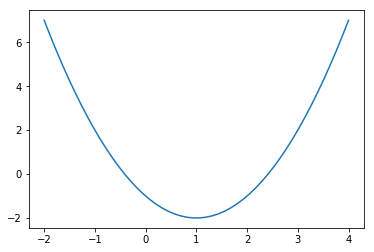

In [11]:
x=np.linspace(-2,4,50)
plt.plot(x, x**2-2*x-1)

Здесь видно, что в точке $x^*=1$ функция принимает минимальное значение равное $-2$. Это значение можно было найти и аналитически использую формулу из школьного учебника.

Теперь рассмотрим более сложный пример $f(x)=\frac{1}{14}\left(x^4+x^3-13x^2-x+19\right)$

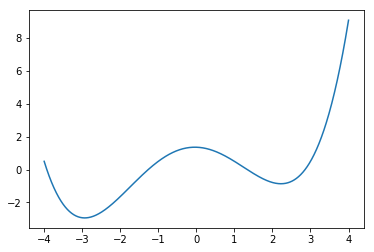

In [12]:
x=np.linspace(-4,4,1000)
coefs = np.array([19,-1,-13,1,1])/14
poly = np.polynomial.Polynomial(coefs)
plt.plot(x, poly(x))

В этом случае все еще можно найти значение функции аналитически, но будь степень побольше, это уже было бы уже невозможно. Выход - численные методы.

Наш график как бы состоит из "горок". И наш минимум функции находится внизу одной из этих горок. Назовем низы горок **локальными минимумами**, а низ горки с минимальным значением функции **глобальным минимумом**. И попытаемся теперь найти не обязательно глобальный, но хотя бы какой нибудь локальный минимум.

Это можно сделать примерно следующим образом. Положим шарик куда нибудь на нашем графике, и отпустим его. Тогда он скатится по горке вниз, прямо в локальный минимум.

In [13]:
starting_point = 0.5
animate_poly_minimization(poly, x ,starting_point)

Более детально - находясь в какой то точке графика, мы проводим касательную и делаем по ней маленький шажок в сторону уменьшения функции. И так пока касательная не станет параллельна оси $x$. Назовем наш шажок, **шагом оптимизации**.

Размер шажка будем делать пропорцинальным крутизне спуска. А крутизна спуска это на самом деле размер угла между касательной и осью $x$.

*Напоминание из школы*: Тангенс угла между касательной и осью $x$ называется **производной**. Зная производную, можно построить касательную. Так что это в общем школьные знания.

In [14]:
animate_poly_minimization_with_slope(poly, x ,starting_point)

Как же достичь глобального минимума? Увы в общем случае никак. Это большая проблема в математике и в машинном обучении. Приходится довольствоваться локальными минимумами. Впрочем люди придумывают методы чтобы "выпрыгивать" из одних локальных оптимумов, попадая в другие, более хорошие (с меньшим значением функции).

Есть также отдельный класс функций - выпуклые. У них всегда один минимум - он же локальный, он же и глобальный (Но обратное не верно, не все функции с одним минимумом - выпуклые).

### Много параметров

В случае многих параметров (или как говорят в математике, в случае многомерного пространства), подход  почти точно такой же. В трехмерном случае мы проводим касательную плоскость, а в больших размерностях гиперплоскость (не надо представлять - не получится) и движимся в сторону наибольшего убывания функции (в сторону где у горки самая больша крутизна спуска).


### Так зачем все это?

Минимизация нам нужна чтобы обучить нашу модель. 

У нас есть функция потерь, назовем ее $L$, зависящая от параметров модели $\theta_1, \theta_2, \ldots, \theta_n$. Как мы решили раньше - чем меньше $L$, тем качественней модель. Поэтому минимизируя $L(\theta)$ мы улучшаем нашу модель или, сказав по другому, *обучаем* ее.

Поэтому процесс обучения модели можно представить как серию оптимизационных шагов, в каждом из которых мы движемся в сторону уменьшения значения функции потерь, немного изменяя значения параметров, пока функция потерь не перестанет уменьшаться. 

<img src="pics/ML_Train.png">



### Что мы скрыли?

* Как находить производные? (Ответ: используя таблицы производных и простые правила) 
* Как находить касательную гиперплость и направление наибольшего убывания? (Ответ: по формулам, используя производные)
* Всегда ли шарик скатится вниз горки? (Ответ: нет, но есть простые способы отследить и избежать "застревания")

## Что дальше?
* Линейные модели для бинарной классификации
* Логистическая регрессия
* Простая нейронная сеть